In [10]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.models import VGG19_Weights

# to read an image from a url
import imageio.v3 as iio

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt

# for importing the image files
import requests
from io import BytesIO

# Import VGG19 and Freeze all layers

In [22]:
vggnet = torchvision.models.vgg19(weights=VGG19_Weights.DEFAULT)

for p in vggnet.parameters():
  p.requires_grad = False

vggnet.eval();

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vggnet.to(device);

# Import Images

In [24]:
# Import Content and Style Images

content_url = 'https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg'

style_url = 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg'

header = {'User-Agent': 'Mozilla/5.0'}

resp = requests.get(content_url, headers=header, timeout=30)
resp.raise_for_status()

img4content = iio.imread(BytesIO(resp.content))

resp = requests.get(style_url, headers=header, timeout=30)
resp.raise_for_status()

img4style = iio.imread(BytesIO(resp.content))


In [25]:
# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [26]:
## These images are really large, which will make training take a long time.
## For VGG16 the mean and SD to normalize are [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225] respectively

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


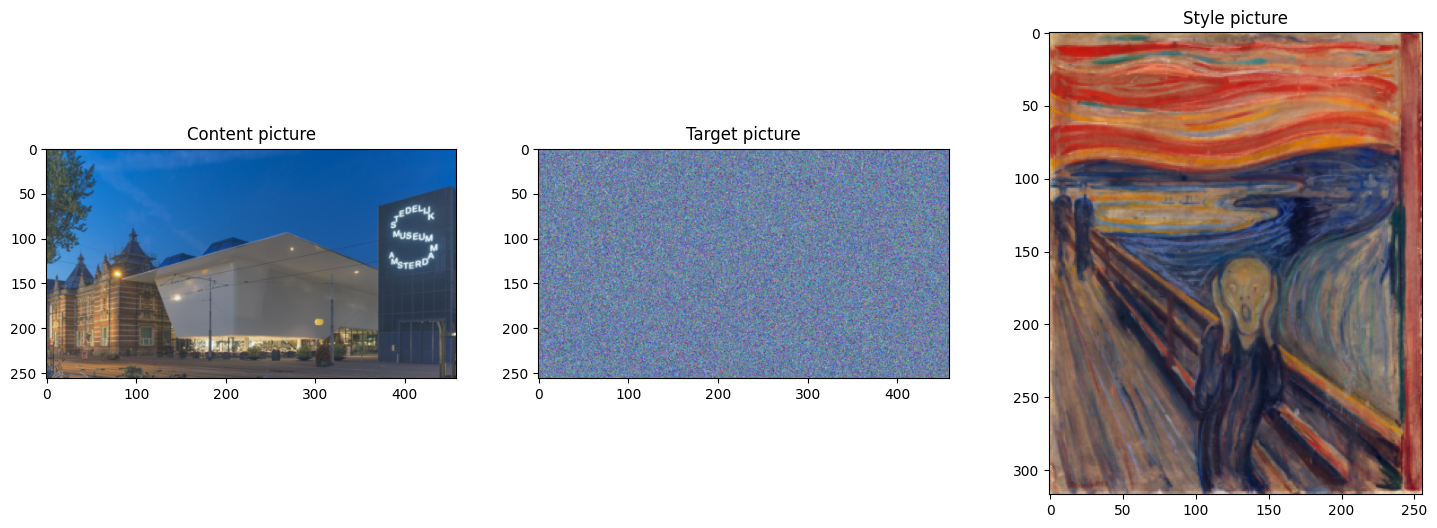

In [31]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show();